In [1]:
# using MKL
using SpecialFunctions
using Plots
# Plots.gr()
# using GLMakie
# using Makie
# using CairoMakie
using LinearAlgebra
using SparseArrays
import JLD
# using Roots
using CSV
using Statistics
using Base.Threads
using DataFrames, Tables
using ThreadsX
using TensorToolbox
using Octavian
using Tullio
using BenchmarkTools

In [2]:
@tullio grad=false

(verbose = false, fastmath = true, threads = true, grad = false, avx = true, cuda = true)

In [3]:
cd();cd("Documents/FXW/STM_votex");pwd()

"/home/physicsmaster/Documents/FXW/STM_votex"

In [4]:
const maxmu, rstep, kf, xi0, ef, omgd, ecut, rangecut = 159/2, 0.01, 1., 7.6, 12., 10., 10., 8.;

In [14]:
Nstates, R = 200, 60.;
ris = collect(0:rstep:R);

In [6]:
const besselzeros = CSV.read("/home/physicsmaster/Documents/FXW/STM_votex/bessel_function_table.CSV", DataFrame, header=false);

alpha(i, m) = besselzeros[Int[m+1], Int[i]][1,1];

scN(i,m) = R*besselj(m + 1, alpha(i, m)) / sqrt(2);

phi(i,m,r)=1/scN(i,m)*besselj(m,alpha(i,m)/R*r);

function phini(mu, switch, basisrange)
    templist = zeros(Int(basisrange[2] - basisrange[1] + 1),Int(R/rstep + 1))
    for i in range(start=basisrange[1], stop=basisrange[2])
        templist[i,:] = phi.(i, abs(mu + switch * 1/2), ris)
    end
    return templist
end

function  ffermi(iotaE, Ttempe)
    Ttempe == 0 ? (iotaE > 0 ? 0 : 1) : 1 / (exp((1.75*(iotaE)/Ttempe)) + 1)
end

function processeigen(HBdG)
    data = eigen(HBdG)
    dataeigbef = vcat(data.values', data.vectors)
    positive_part = [dataeigbef[:,i] for i in 1:length(dataeigbef[1,:]) if dataeigbef[:,i][1] > 0]
    negative_part = sort([dataeigbef[:,i] for i in 1:length(dataeigbef[1,:]) if dataeigbef[:,i][1] < 0], rev=true);
    dataeigbef = hcat(hcat(positive_part...), hcat(negative_part...))
    return dataeigbef
end;
function generate_phi()
    global phinivm = zeros(Integer(maxmu+1/2), Nstates, Integer(R/rstep+1))
    global phinivp = zeros(Integer(maxmu+1/2), Nstates, Integer(R/rstep+1))
    @threads for i in 1:Integer(maxmu+1/2)
        phinivm[i,:,:] = phini(i-1/2, -1, [1, Nstates]);
    end
    for i in 1:Integer(maxmu+1/2-1)
        phinivp[i,:,:] = phinivm[i+1, :, :]
    end
    phinivp[end,:,:] = phini(maxmu, 1, [1, Nstates]);
end;
function HBdGinit(br)
    mu = br[3]
    spdiagm(vcat(map(i->ef/(kf*xi0)^2 * (alpha(Int(i), abs(mu - 1/2))/R)^2 - ef, br[1]:br[2]), map(i-> -ef/(kf*xi0)^2 * (alpha(Int(i), abs(mu + 1/2))/R)^2 + ef, br[1]:br[2])))
end;
function HBdG(mu)
    cycle == 1 ? deltamat = phinivm[Int(mu+1/2),:,:] * spdiagm(rstep.*ris.* abs.(deltainit)) * phinivp[Int(mu+1/2),:,:]' : deltamat = phinivm[Int(mu+1/2),:,:] * spdiagm(rstep.*ris.* abs.(deltanow)) * phinivp[Int(mu+1/2),:,:]';
    hbdginitmat = hbdginitmatall[Int(mu + 1/2),:,:];
    hbdginitmat[1 : Nstates, Nstates + 1 : 2*Nstates] = deltamat;
    hbdginitmat[Nstates + 1 : 2*Nstates, 1 : Nstates] = transpose(deltamat);
    return hbdginitmat
end;
function deltaana(xi0, xi1, r)
    r == 0 ? 0 : 1/(1+(xi0*exp(-(r/xi1)))/r)
end;

function fdelta(mu, dataeigbef)

    cutnumberp = filter(x->x>0 && x < omgd, dataeigbef[1,:]) |> length
    cutnumbern = filter(x->x<0 && x> -omgd, dataeigbef[1,:]) |> length
    c1 = hcat(dataeigbef[2:Nstates+1, 1:cutnumberp], dataeigbef[2:Nstates+1, Nstates+1:Nstates+cutnumbern]);
    c2 = hcat(dataeigbef[Nstates+2:end, 1:cutnumberp], dataeigbef[Nstates+2:end, Nstates+1:Nstates+cutnumbern])
    fE = spdiagm(vcat(ffermi.(dataeigbef[1,1:cutnumberp], temp), ffermi.(dataeigbef[1,Nstates+1:Nstates+cutnumbern], temp)))
    fmE = spdiagm(vcat(ffermi.(-dataeigbef[1,1:cutnumberp], temp), ffermi.(-dataeigbef[1,Nstates+1:Nstates+cutnumbern], temp)))
    tab1 = c1 * fE * conj(c2)'
    tab2 = c1 * fmE * conj(c2)'
    tab3 = c2 * conj(c2)'
    new_delta = g * diag(
        matmul(matmul(phinivm[Int(mu+1/2),:,1:Int(rangecut/rstep+1)]', (tab2 - tab1)),
         conj(phinivp[Int(mu+1/2),:,1:Int(rangecut/rstep+1)]))) # constrain range of delta
end;


function fcycle(epochs=40, plot=false, conv=1e-4)

    global cycle, deltanow, deltadata, dataeigbefall

    deltanow = zeros(Int(R/rstep+1))

    deltadata = reshape(deltainit, :, 1)

    dataeigbefall = zeros(Int(maxmu+1/2), 2*Nstates+1, 2*Nstates);
    
    while (if cycle == 1 true; else norm(deltadata[:,end-1] - deltadata[:, end]) / norm(deltadata[:, end-1]) > conv end) && cycle < epochs    

        @threads for mu in 1/2:1:maxmu

            dataeigbefall[Int(mu+1/2),:,:] = processeigen(HBdG(mu))   

        end

        deltanow = vcat(sum(fdelta(mu, dataeigbefall[Int(mu+1/2),:,:]) for mu in 1/2:1:maxmu), ones(Int(R/rstep - rangecut/rstep)))

        deltadata = hcat(deltadata, deltanow)
        cycle += 1
        println("cycle = $cycle")
        println("convergency: ", norm(deltadata[:,end-1] - deltadata[:, end]) / norm(deltadata[:, end-1]), "\n")
        
        # display(lines(ris, deltanow[], color=:red))
        if plot == true display(Plots.plot(ris, deltanow, color=:red)) else nothing end
    end
    @threads for mu in 1/2:1:maxmu

        dataeigbefall[Int(mu+1/2),:,:] = processeigen(HBdG(mu))   

    end
    # Plots.plot(ris, deltanow, linewidth=2, color=:red, title="Δnow(r)")
end;

gaussian(IotaE, omega, sigma=0.01) = 1/(sqrt(2pi) * sigma) * exp(-1/2 * ((omega - IotaE) / sigma)^2)

function ldos(mu, dataeigbef, omega, sigma)

    c1 = dataeigbef[2:Nstates+1, :];
    c2 = dataeigbef[Nstates+2:end, :];
    dfvec = spdiagm(gaussian.(dataeigbef[1,:], omega, sigma))
    dfvecm = spdiagm(gaussian.(-dataeigbef[1,:], omega, sigma))
    tab1 = c1 * dfvec * conj(c1)'
    tab2 = c2 * dfvecm * conj(c2)'
    dos = diag(matmul(matmul(phinivm[Int(mu+1/2),:,1:Int(rangecut/rstep+1)]' , tab1) , conj(phinivm[Int(mu+1/2),:,1:Int(rangecut/rstep+1)]))) + 
    diag(matmul(matmul(phinivp[Int(mu+1/2),:,1:Int(rangecut/rstep+1)]' , tab2) , conj(phinivp[Int(mu+1/2),:,1:Int(rangecut/rstep+1)])))  # constrain range of delta
end;


function refinedos(reso, save_data=false, energyrange=1.2, energystep=0.03)
    
    omega_max = energyrange
    omega_step = energystep
    sigma = reso
    omega_list = [-omega_max:omega_step:omega_max;]
    dos = zeros(Int(rangecut/rstep + 1), length(omega_list))
    @threads for i in 1:length(omega_list)

        dos[:, i] = ThreadsX.sum(ldos(j-1/2, dataeigbefall[j,:,:], omega_list[i], sigma) for j in 1:size(dataeigbefall)[1])

    end

    refined_dos = hcat([0.0;[range(0, rangecut, step=rstep);]],vcat(omega_list',dos))

    if save_data == true
        JLD.save("refined_dos_data.jld", "sigma=$(sigma)", refined_dos)
        CSV.write("dos_sigma=$(sigma)_julia.csv", DataFrame(refined_dos, :auto))
    else
        nothing;
    end
    
    # display(Plots.surface(omega_list, [0:rstep:rangecut;], refined_dos[2:end, 2:end], title="sigma=$(sigma)"))
    # display(contour(omega_list, [0:rstep:rangecut;], refined_dos[2:end, 2:end], title="sigma=$(sigma)"))

    return refined_dos

end;

In [15]:
generate_phi(); # generate bessel funciton basis if necessary, it takes about several minutes, or just load them

JLD.save("/home/physicsmaster/Documents/FXW/STM_votex/julia_Nstates=$Nstates,R=$R,rstep=$rstep,maxμ=$maxmu,phiniv.jld", "-1", phinivm, "1", phinivp)

In [16]:
phiniv = Dict("-1"=>phinivm, "1"=>phinivp)
br = [[1, Nstates, i-1/2] for i in 1:Int(maxmu+1/2)]
hbdginitmatall = permutedims(cat([HBdGinit(br[i]) for i in 1:Int(maxmu+1/2)]...; dims=3), [3,1,2]);
deltainit = convert(Vector{Float64}, deltaana.(10.,2., ris));
temp = 0.01;
g = 1/2.4 * (-1)/log(1/(2*omgd));

In [17]:
hbdginitmatall[1,:,:]

400×400 Matrix{Float64}:
 -11.9997    0.0       0.0     …    0.0       0.0      0.0       0.0
   0.0     -11.9982    0.0          0.0       0.0      0.0       0.0
   0.0       0.0     -11.9957       0.0       0.0      0.0       0.0
   0.0       0.0       0.0          0.0       0.0      0.0       0.0
   0.0       0.0       0.0          0.0       0.0      0.0       0.0
   0.0       0.0       0.0     …    0.0       0.0      0.0       0.0
   0.0       0.0       0.0          0.0       0.0      0.0       0.0
   0.0       0.0       0.0          0.0       0.0      0.0       0.0
   0.0       0.0       0.0          0.0       0.0      0.0       0.0
   0.0       0.0       0.0          0.0       0.0      0.0       0.0
   0.0       0.0       0.0     …    0.0       0.0      0.0       0.0
   0.0       0.0       0.0          0.0       0.0      0.0       0.0
   0.0       0.0       0.0          0.0       0.0      0.0       0.0
   ⋮                           ⋱                               
   0.0       0

In [11]:
hbdginitmatall[1,:,:]

400×400 Matrix{Float64}:
 -11.9995    0.0       0.0       0.0     …    0.0       0.0       0.0
   0.0     -11.9975    0.0       0.0          0.0       0.0       0.0
   0.0       0.0     -11.9938    0.0          0.0       0.0       0.0
   0.0       0.0       0.0     -11.9884       0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0     …    0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0     …    0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   ⋮                                     ⋱                      


In [9]:
# const phinivm = JLD.load("/home/physicsmaster/Documents/FXW/STM_votex/julia_Nstates=$Nstates,R=$R,rstep=$rstep,maxμ=$maxmu,phiniv.jld")["-1"]
# const phinivp = JLD.load("/home/physicsmaster/Documents/FXW/STM_votex/julia_Nstates=$Nstates,R=$R,rstep=$rstep,maxμ=$maxmu,phiniv.jld")["1"]
# const phiniv = Dict("-1"=>phinivm, "1"=>phinivp)
# const br = [[1, Nstates, i-1/2] for i in 1:Int(maxmu+1/2)]
# const hbdginitmatall = permutedims(cat([HBdGinit(br[i]) for i in 1:Int(maxmu+1/2)]...; dims=3), [3,1,2]);
# const deltainit = convert(Vector{Float64}, deltaana.(10.,2., ris));
# const temp = 0.01;
# const g = 1/2.4 * (-1)/log(1/(2*omgd));

In [22]:
# generate self-consistent solutions

cycle = 1

fcycle(40, false)

cycle = 2
convergency: 0.035168710885659295

cycle = 3
convergency: 0.02733478441644386

cycle = 4
convergency: 0.020703781082738917

cycle = 5
convergency: 0.015383427467930106

cycle = 6
convergency: 0.01118286615528787

cycle = 7
convergency: 0.007982566148690478

cycle = 8
convergency: 0.005620004831651785

cycle = 9
convergency: 0.003917107650329487

cycle = 10
convergency: 0.0027107677988579353

cycle = 11
convergency: 0.0018666090008516954

cycle = 12
convergency: 0.0012809260927703243

cycle = 13
convergency: 0.0008769668640916948

cycle = 14
convergency: 0.0005994675566070887

cycle = 15
convergency: 0.0004093583896856103

cycle = 16
convergency: 0.00027935517161034037

cycle = 17
convergency: 0.0001905607525114598

cycle = 18
convergency: 0.00012995930688527072

cycle = 19
convergency: 8.861915879727614e-5



In [23]:
dataeigbefall[1:10,1,1]'

1×10 adjoint(::Vector{Float64}) with eltype Float64:
 0.075045  0.157677  0.237762  0.305889  …  0.494605  0.528871  0.559185

In [32]:
dataeigbefall[1:10,1,1]'

1×10 adjoint(::Vector{Float64}) with eltype Float64:
 0.0767325  0.164181  0.246666  0.316078  …  0.501736  0.534751  0.564033

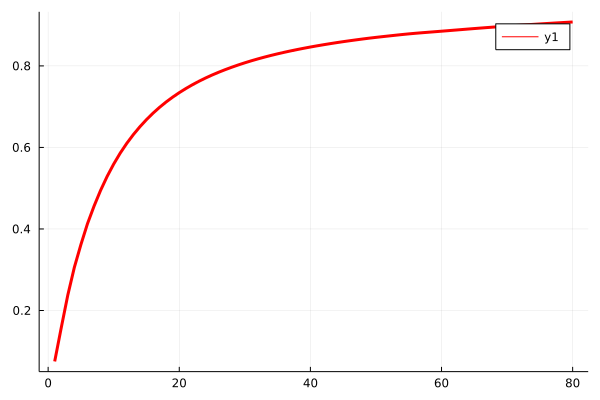

In [20]:
Plots.plot(dataeigbefall[:,1,1], lw=3, color=:red)

**Plot Self-consistent DOS**

In [ ]:
Plots.surface(collect(1:3), collect(1:3), rand(3,3))

In [50]:
dos_list = refinedos.([0.01, 0.05, 0.1]);

In [57]:
dos_list_new = refinedos.([0.01, 0.05, 0.1]);

In [ ]:
dos_list[1][2:end, 2:end]

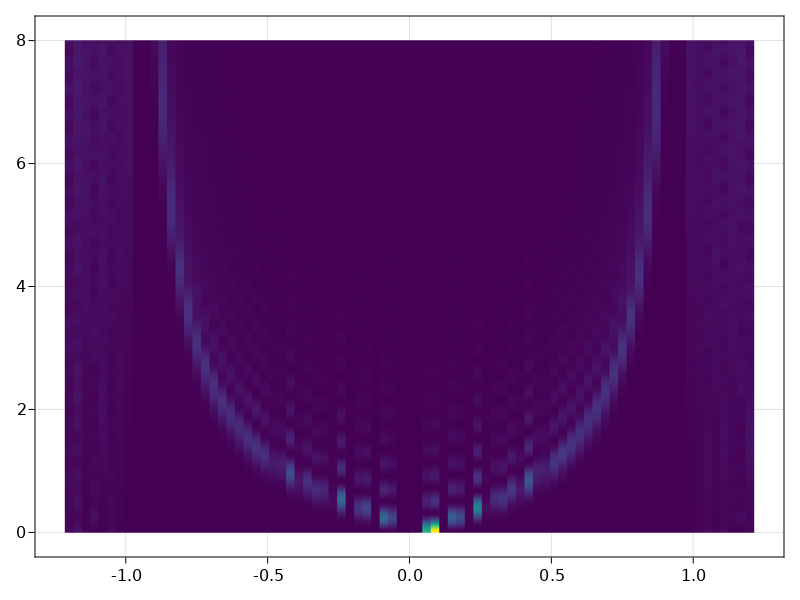

In [19]:
contour(-1.2:0.03:1.2, 0:rstep:rangecut, dos_list[1][2:end, 2:end]', levels=1, linewidth=1, fillrange=true)

**non-self consistent with impurities**

In [25]:
function matv(r0=1.0, v0=1.0, theta0=pi/3, n=1, npr=1)
    
    coefficients = [(if sigma==sigmapr==-1; v0 elseif sigma==sigmapr==1; -v0 else v0 end) * r0 * 
    exp(im*(mupr-mu)*theta0) * exp(im*(sigmapr-sigma) * theta0 / 2.0) for sigma in [-1, 1], 
    sigmapr in [-1, 1], 
    mu in 1/2:1:maxmu, 
    mupr in 1/2:1:maxmu]
    
    c = reshape(dataeigbefall[:,2:end,n], (Int(maxmu+1/2), Nstates, 2))
    
    wave_func=[phi.([1:Nstates;], mu+sig/2, r0) for mu in 1/2:1:maxmu, sig in [-1,1]]
    
    @tullio V_imp[sigma,sigmapr, mu, mupr] := coefficients[sigma, sigmapr, mu, mupr] .* 
    (c[mu, l, sigma] * wave_func[mu, sigma][l] * c[mupr, lpr, sigmapr] * wave_func[mupr, sigmapr][lpr])

    [
        V_imp[1,1,:,:] V_imp[1,2,:,:];
        V_imp[2,1,:,:] V_imp[2,2,:,:]
    ]
end;

In [26]:
# matv(r0=1.0,v0=1.0,theta0=pi/3, n=1, npr=1)
function generate_imp_matrix(imp_num::Int, positions::Vector{Vector{Float64}})::Matrix{ComplexF64}

    for position in positions
        println("impurity $(Int(position[1])):\t 
        radius: $(round(position[2]; digits=2))ξ\t 
        angle: $(round(position[3] / pi * 180; digits=2))°\n")
    end

    imp_matrix = zeros(ComplexF64, (imp_num, Int(2 * maxmu + 1), Int(2 * maxmu + 1)));

    @threads for position in positions

        imp_matrix[Int(position[1]), :, :] = matv(position[2], 1.0, position[3], 1, 1)

    end

    imp_matrix = sum(imp_matrix, dims=1)[1,:,:];

    return imp_matrix

end;

In [27]:
function psiallmu(sigma, n)

    reduce(hcat, [phiniv["$sigma"][i,:,1:Int(rangecut/rstep+1)]' * 
    (sigma == -1 ? dataeigbefall[1:Int(maxmu+1/2), 2:Nstates+1, n] : dataeigbefall[1:Int(maxmu+1/2), Nstates+2:end, 1])[i,:] for i in 1:Int(maxmu+1/2)])
    
end;

In [28]:
function emumat(n)

    spdiagm([dataeigbefall[:, 1, n]; dataeigbefall[:,1, Nstates+n]])

end

imp_mat_eigen(imp_matrix::Matrix{ComplexF64}) = vcat((eigen(emumat(1) + imp_matrix; permute=true, scale=true).values |> real)',
 eigen(emumat(1) + imp_matrix; permute=true, scale=true).vectors);

In [29]:
function ldosimpuritynew(sigma, energy, theta, reso)

    templist = zeros(ComplexF64, Int(2*maxmu+1), Int((2*maxmu+1) / maxn), maxn)

    for i in 1:Int(2*maxmu+1)
        
        templist[i,:,:] = [reshape(impeigen[2:end,j], (:, maxn)) for j in 1:Int(2*maxmu+1)][i]
    end

    abs2.(reduce(+, [(sigma == -1 ? permutedims(templist[:, 1:Int(maxmu+1/2),:], [3,1,2]) : permutedims(templist[:, Int(maxmu+1/2+1):Int(2*maxmu+1),:], [3,1,2]))[i,:,:] * 
    ([exp(im*(mu+1/2)*theta) for mu in 1/2:1:maxmu, _ in 1:maxn][:,i] .* psiallmusigma["$sigma"][i]') for i in 1:maxn]))' *
    gaussian.(impeigen[1,:] |> real, energy, reso)

end;

In [30]:
function ldosimpall(energy::Float64, reso::Float64, theta_step::Float64)

    theta_list = [0:theta_step:2pi;]

    contaniner = zeros(Int(rangecut/rstep+1.0), length(theta_list))

    @threads for theta in theta_list

        contaniner[:, Int(round(theta / theta_step + 1.0))] = ldosimpuritynew(1, energy, theta, reso) +
         ldosimpuritynew(-1, energy, theta, reso)
                                                            
    end
    
    return contaniner
end;

In [31]:
maxn = 1 # including only the first energy level

const psiallmusigma = Dict("-1"=>[psiallmu(-1, n) for n in 1:maxn], "1"=>[psiallmu(1, n) for n in 1:maxn]); # for ldos calculations

impurity 1:	 
        radius: 2.78ξ	 
        angle: 25.85°

impurity 2:	 
        radius: 2.51ξ	 
        angle: 330.69°

impurity 3:	 
        radius: 1.51ξ	 
        angle: 34.25°

impurity 4:	 
        radius: 1.56ξ	 
        angle: 116.12°



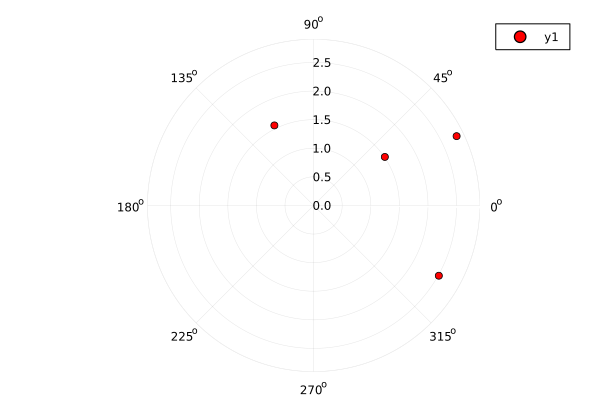

In [32]:
imp_num, max_radius, theta_step = 4, 4.0, 0.1 # number of impurities and distance maximum of the impurities away from the center

rangelist = [0:rstep:rangecut;];
thetalist = [0:theta_step:2pi;];

positions = [[i, max_radius * rand(), 2pi * rand()] for i in 1:imp_num] # randomly generate the positions of impurities

# generate_imp_matrix(1, 3.0, [[1, 1.0, pi/3]]);
imp_matrix = generate_imp_matrix(imp_num, positions);

impeigen = imp_mat_eigen(imp_matrix);

Plots.scatter([positions[i][3] for i in 1:length(positions)],
            [positions[i][2] for i in 1:length(positions)], proj=:polar, color=:red)


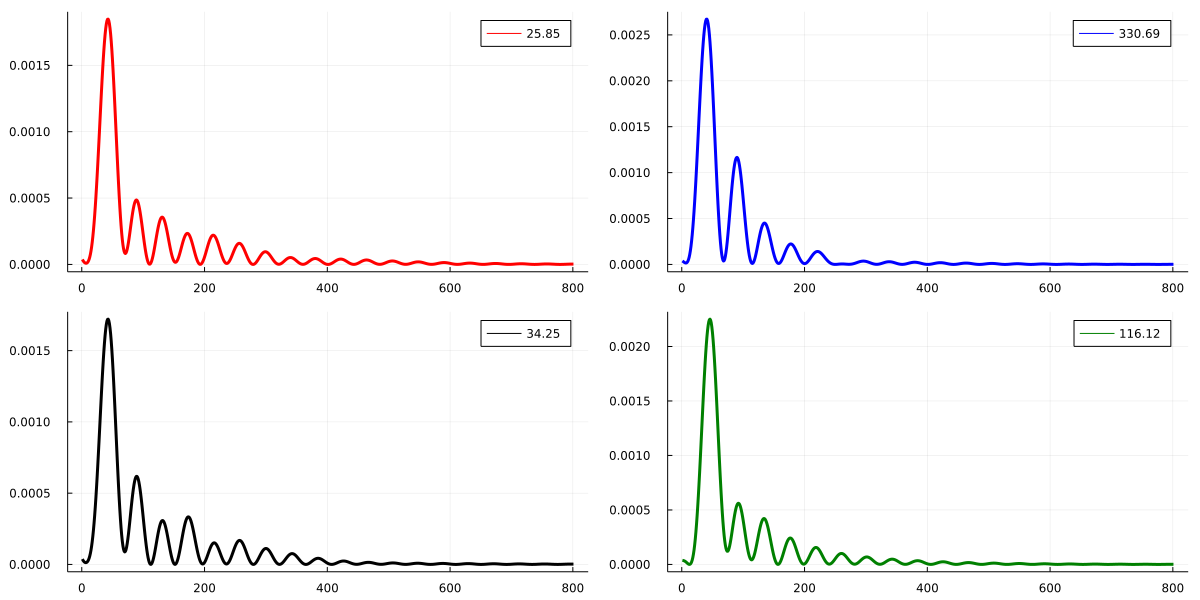

In [33]:
Plots.plot(
    ldosimpuritynew.(-1, 0.3, [positions[i][3] for i in 1:length(positions)], 0.01) + ldosimpuritynew.(1, 0.3,  [positions[i][3] for i in 1:length(positions)], 0.01),
    layout=(2,2),
    label=[round(positions[i][3] / pi * 180; digits=2) for i in 1:length(positions)]',
    lw=3,
    size = (1200, 600),
    color = [:red :blue :black :green]
    )

calculating sigma = 0.01


calculating sigma = 0.1


calculating sigma = 0.2


calculating sigma = 0.5


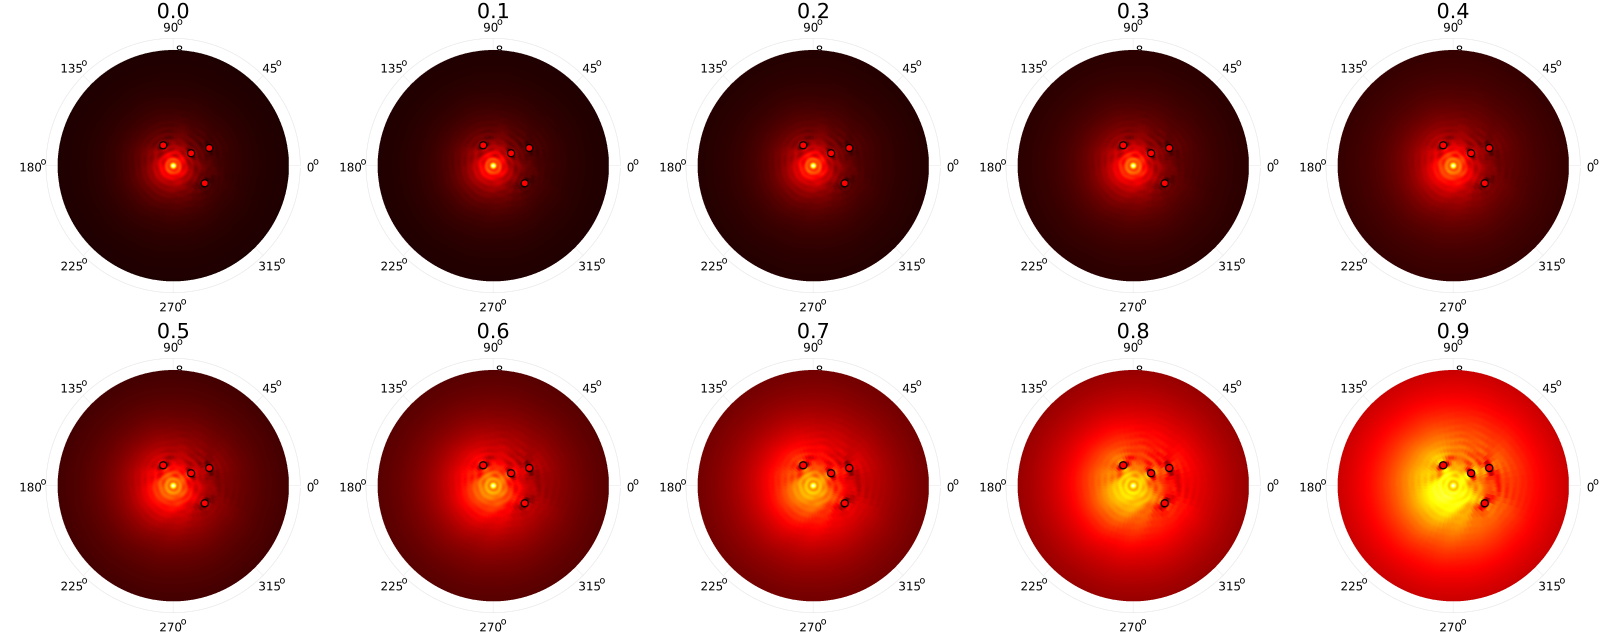

In [35]:
for sigma in [0.01, 0.1, 0.2, 0.5]
    
    println("calculating sigma = $sigma")    
    
    pp = []

    for energy in 0.0:0.1:0.9

        ldostemp = ldosimpall(energy, sigma, theta_step)

        p = Plots.heatmap(thetalist, rangelist, ldostemp, proj=:polar, legend=false, color=:hot)

        Plots.scatter!([positions[i][3] for i in 1:length(positions)],
            [positions[i][2] for i in 1:length(positions)], proj=:polar, color=:red)

        push!(pp, p)

        # println("write julia_dos_$(imp_num)imp_$(energy).csv")

        # CSV.write("julia_dos_$(imp_num)imp_reso$(sigma)_ene$(energy).csv", DataFrame(ldostemp,:auto)) # write ldos data to disk

    end

    # CSV.write("julia_impdos_0.5.csv", DataFrame(ldosimpall(0.5, 0.01),:auto))

    display(Plots.plot(pp..., proj=:polar, layout=(2, 5), size=(320 * 5, 320 * 2), title=[0.0:0.1:0.9;]'))

end;